/Users/akhilkumar/Desktop/MSCS-SEM3/Birds-Acoustics-Identifier-Model-/env/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=576
  return f(*args, **kwargs)


Epoch 1/20


2024-12-11 14:23:29.939539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


52/52 [==============================] - 13s 250ms/step - loss: 4.6889 - accuracy: 0.0133 - val_loss: 4.6522 - val_accuracy: 0.0145
Epoch 2/20
52/52 [==============================] - 13s 251ms/step - loss: 4.6111 - accuracy: 0.0169 - val_loss: 4.6012 - val_accuracy: 0.0242
Epoch 3/20
52/52 [==============================] - 13s 246ms/step - loss: 4.5570 - accuracy: 0.0127 - val_loss: 4.5606 - val_accuracy: 0.0097
Epoch 4/20
52/52 [==============================] - 13s 249ms/step - loss: 4.5204 - accuracy: 0.0181 - val_loss: 4.5341 - val_accuracy: 0.0242
Epoch 5/20
52/52 [==============================] - 13s 248ms/step - loss: 4.4810 - accuracy: 0.0338 - val_loss: 4.4664 - val_accuracy: 0.0314
Epoch 6/20
52/52 [==============================] - 13s 250ms/step - loss: 4.4184 - accuracy: 0.0368 - val_loss: 4.3598 - val_accuracy: 0.0773
Epoch 7/20
52/52 [==============================] - 13s 249ms/step - loss: 4.2743 - accuracy: 0.0743 - val_loss: 4.2440 - val_accuracy: 0.0894
Epoch 8/20

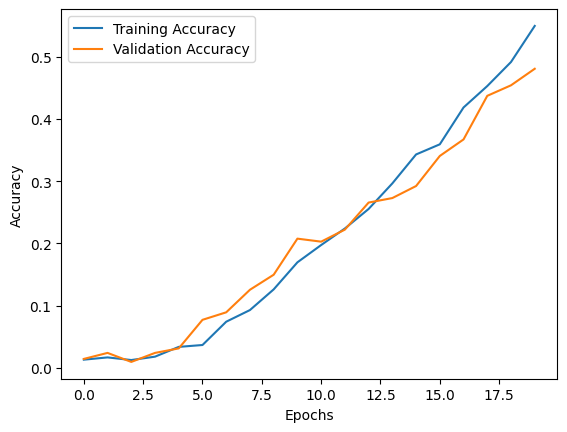

In [3]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Step 1: Load Audio and Convert to Spectrogram
def audio_to_spectrogram(audio_path, img_size=(128, 128)):
    y, sr = librosa.load(audio_path, sr=None)  # Load audio file
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=img_size[0], fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to dB
    spectrogram = np.resize(S_dB, img_size)  # Resize to fixed size
    return spectrogram

# Step 2: Prepare Dataset
def prepare_data(data_dir, img_size=(128, 128)):
    data = []
    labels = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                spectrogram = audio_to_spectrogram(file_path, img_size)
                data.append(spectrogram)
                labels.append(os.path.basename(root))
    return np.array(data), np.array(labels)

# Set your dataset path
data_dir = "/Users/akhilkumar/Desktop/MSCS-SEM3/Birds-Acoustics-Identifier-Model-/bird_sounds/Voice of Birds/Voice of Birds"
data, labels = prepare_data(data_dir)

# Step 3: Preprocess Data
data = data / 255.0  # Normalize pixel values

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels)

# Reshape data to add channel dimension
data = data[..., np.newaxis]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Step 4: Build CNN Model
def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(labels.shape[1], activation='softmax')
    ])
    return model

input_shape = (128, 128, 1)
model = create_model(input_shape)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Train Model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Step 6: Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 7: Save Model
model.save("bird_sound_cnn_model_new.h5")

# Step 8: Visualize Training History4
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [8]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the Saved Model
model = load_model("bird_sound_cnn_model_new.h5")

# Step 2: Fit Label Encoder (You need to have the label data from the training set)
def fit_label_encoder(data_dir):
    labels = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".wav"):
                labels.append(os.path.basename(root))  # Using folder names as labels
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)  # Fit the encoder on the bird names (labels)
    return label_encoder

# Assuming the training dataset folder is the same as the one used during training
data_dir = "/Users/akhilkumar/Desktop/MSCS-SEM3/Birds-Acoustics-Identifier-Model-/bird_sounds/Voice of Birds/Voice of Birds"
label_encoder = fit_label_encoder(data_dir)

# Step 3: Convert Input Audio to Spectrogram
def audio_to_spectrogram(audio_path, img_size=(128, 128)):
    y, sr = librosa.load(audio_path, sr=None)  # Load audio file
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=img_size[0], fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to dB
    spectrogram = np.resize(S_dB, img_size)  # Resize to fixed size
    return spectrogram

# Step 4: Make a Prediction
def predict_bird(audio_path, model, label_encoder, img_size=(128, 128)):
    # Convert audio to spectrogram
    spectrogram = audio_to_spectrogram(audio_path, img_size)
    
    # Normalize the spectrogram
    spectrogram = spectrogram / 255.0
    
    # Reshape to match the input shape of the model
    spectrogram = spectrogram[..., np.newaxis]  # Add channel dimension
    spectrogram = np.expand_dims(spectrogram, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(spectrogram)
    
    # Decode the predicted label
    predicted_label = np.argmax(prediction, axis=1)
    bird_name = label_encoder.inverse_transform(predicted_label)
    
    return bird_name[0]

# Step 5: Test with an Example Audio File
audio_file = "/Users/akhilkumar/Desktop/MSCS-SEM3/Birds-Acoustics-Identifier-Model-/bird_sounds/Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan5.wav"
predicted_bird = predict_bird(audio_file, model, label_encoder)

print(f"Predicted Bird: {predicted_bird}")


1/1 [==============================] - 0s 82ms/step
Predicted Bird: Andean Guan_sound


In [ ]:
bird_classification_new.ipynb
